In [76]:
import pickle

import os
import sys
print(os.getcwd())
sys.path.append("../WanPy")

import pythTB_wan
import matplotlib.pyplot as plt
import numpy as np

/Users/treycole/Codes/WanPy/dev notebooks


In [77]:
WFs = np.load(
    "/Users/treycole/Codes/WanPy/dev notebooks/data/C=-1.0_Delta=1_t0=0.4_tprime=0.5_n_occ=25_WFs.npy",
    allow_pickle=True
    )
WFs_dict = WFs.item()
WFs_dict

{24: <pythTB_wan.Wannier at 0x3533ba8c0>,
 23: <pythTB_wan.Wannier at 0x3c320f880>,
 22: <pythTB_wan.Wannier at 0x3c320ee90>,
 21: <pythTB_wan.Wannier at 0x3c320e380>,
 20: <pythTB_wan.Wannier at 0x3c320ea10>,
 19: <pythTB_wan.Wannier at 0x3c320ecb0>,
 18: <pythTB_wan.Wannier at 0x3c320e4a0>,
 17: <pythTB_wan.Wannier at 0x3c320e290>,
 16: <pythTB_wan.Wannier at 0x3c320cdf0>,
 15: <pythTB_wan.Wannier at 0x3c320d780>,
 14: <pythTB_wan.Wannier at 0x3c320da50>,
 13: <pythTB_wan.Wannier at 0x3c320ca30>,
 12: <pythTB_wan.Wannier at 0x3c31f3280>,
 11: <pythTB_wan.Wannier at 0x3c42d6440>,
 10: <pythTB_wan.Wannier at 0x36fe13370>,
 9: <pythTB_wan.Wannier at 0x36fe12710>,
 8: <pythTB_wan.Wannier at 0x36fe13820>,
 7: <pythTB_wan.Wannier at 0x36fe13100>,
 6: <pythTB_wan.Wannier at 0x36fe12b90>,
 5: <pythTB_wan.Wannier at 0x36fe11db0>,
 4: <pythTB_wan.Wannier at 0x36fe121a0>,
 3: <pythTB_wan.Wannier at 0x36fe12470>,
 2: <pythTB_wan.Wannier at 0x36fe115d0>,
 1: <pythTB_wan.Wannier at 0x36fdf7b50>}

In [78]:
n_WFs = np.array(list(WFs_dict.keys()))
n_occ = n_WFs[0]+1
WF_fill_frac = n_WFs/n_occ
omega_til_lst = np.array([wf.omega_til for wf in list(WFs_dict.values())])
omega_i_lst = np.array([wf.omega_i for wf in list(WFs_dict.values())])
avg_omega_til = omega_til_lst / n_WFs
avg_omega_i = omega_i_lst / n_WFs

print(f"# occupied bands: {n_occ}")

# occupied bands: 25


Text(0.5, 1.0, "C=-1.0 $\\Delta$ = 1 $t_0=0.4$ $t'=0.5$")

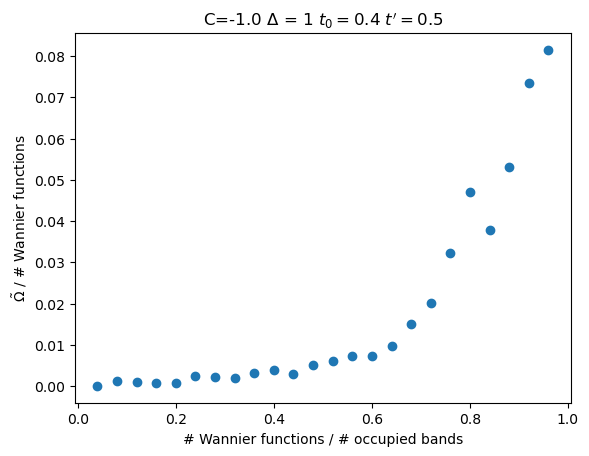

In [79]:
plt.scatter(WF_fill_frac, avg_omega_til)
plt.ylabel(r'$\tilde{\Omega}$ / # Wannier functions')
plt.xlabel('# Wannier functions / # occupied bands')
plt.title(r"C=-1.0 $\Delta$ = 1 $t_0=0.4$ $t'=0.5$")

Text(0.5, 1.0, "C=-1.0 $\\Delta$ = 1 $t_0=0.4$ $t'=0.5$")

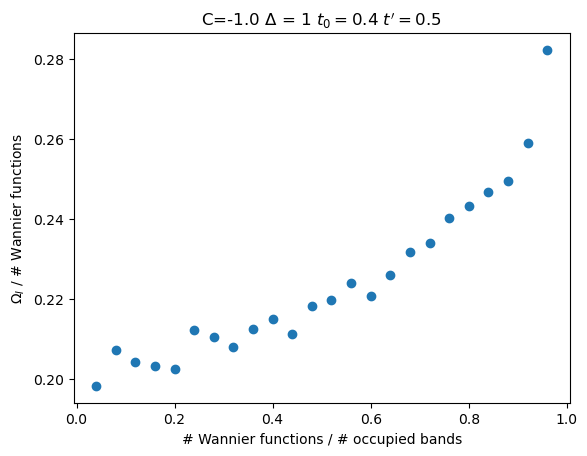

In [82]:
plt.scatter(WF_fill_frac, avg_omega_i)
plt.ylabel(r'$\Omega_I$ / # Wannier functions')
plt.xlabel('# Wannier functions / # occupied bands')
plt.title(r"C=-1.0 $\Delta$ = 1 $t_0=0.4$ $t'=0.5$")